In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import seaborn as sns
import zipfile
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False

print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy')>0.9) and (logs.get('val_accuracy')>0.9):
      print("\nReached 90.0% accuracy on both sets so cancelling training!")
      self.model.stop_training = True

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

Tensorflow version 2.9.2


In [ ]:
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']
colors = sns.color_palette(None, len(class_names))
colors[-1] = (0, 0, 0)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip \
    -O /tmp/fcnn-dataset.zip

# extract the downloaded dataset to a local directory: /tmp/fcnn
local_zip = '/tmp/fcnn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/fcnn')
zip_ref.close()

# download the weights
!wget https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

--2022-11-14 07:04:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125577577 (120M) [application/zip]
Saving to: ‘/tmp/fcnn-dataset.zip’

/tmp/fcnn-dataset.z 100%[===================>] 119.76M   256MB/s    in 0.5s    

2022-11-14 07:04:43 (256 MB/s) - ‘/tmp/fcnn-dataset.zip’ saved [125577577/125577577]

--2022-11-14 07:04:45--  https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-releas

In [ ]:
def get_train_set(path_X, path_Y, train = True):
    lenX = len(os.listdir(path_X))
    X = tf.keras.utils.image_dataset_from_directory(path_X, labels=None, shuffle = False,
                                color_mode='rgb', batch_size = 64, image_size=(224, 224), validation_split=None,)
    X = X.map(lambda x: tf.cast(x, tf.float32)/127.5 - 1, num_parallel_calls=tf.data.AUTOTUNE)

    Y = tf.keras.utils.image_dataset_from_directory(path_Y, labels=None,  shuffle = False, 
                                color_mode='grayscale', batch_size = 64, image_size=(224, 224), validation_split=None,)
    def mask(y):
        stack_list = []
        for c in range(len(class_names)):
            mask = tf.equal(tf.cast(y[:, :,:, 0], tf.int32), tf.constant(c))
            stack_list.append(tf.cast(mask, dtype=tf.int32))
        return tf.stack(stack_list, axis=3)
    Y = Y.map(mask) 


    ds = tf.data.Dataset.zip((X, Y))
    if train:
        ds = ds.shuffle(100, reshuffle_each_iteration=True)
    ds = ds.repeat()
    if train:
        ds = ds.prefetch(-1)

    return ds

path = '/tmp/fcnn/dataset1/'
train = get_train_set(path + 'images_prepped_train', path + 'annotations_prepped_train')
test = get_train_set(path + 'images_prepped_test', path + 'annotations_prepped_test', train = False)
for i, j in train.take(1):
  break

Found 367 files belonging to 1 classes.
Found 367 files belonging to 1 classes.
Found 101 files belonging to 1 classes.
Found 101 files belonging to 1 classes.


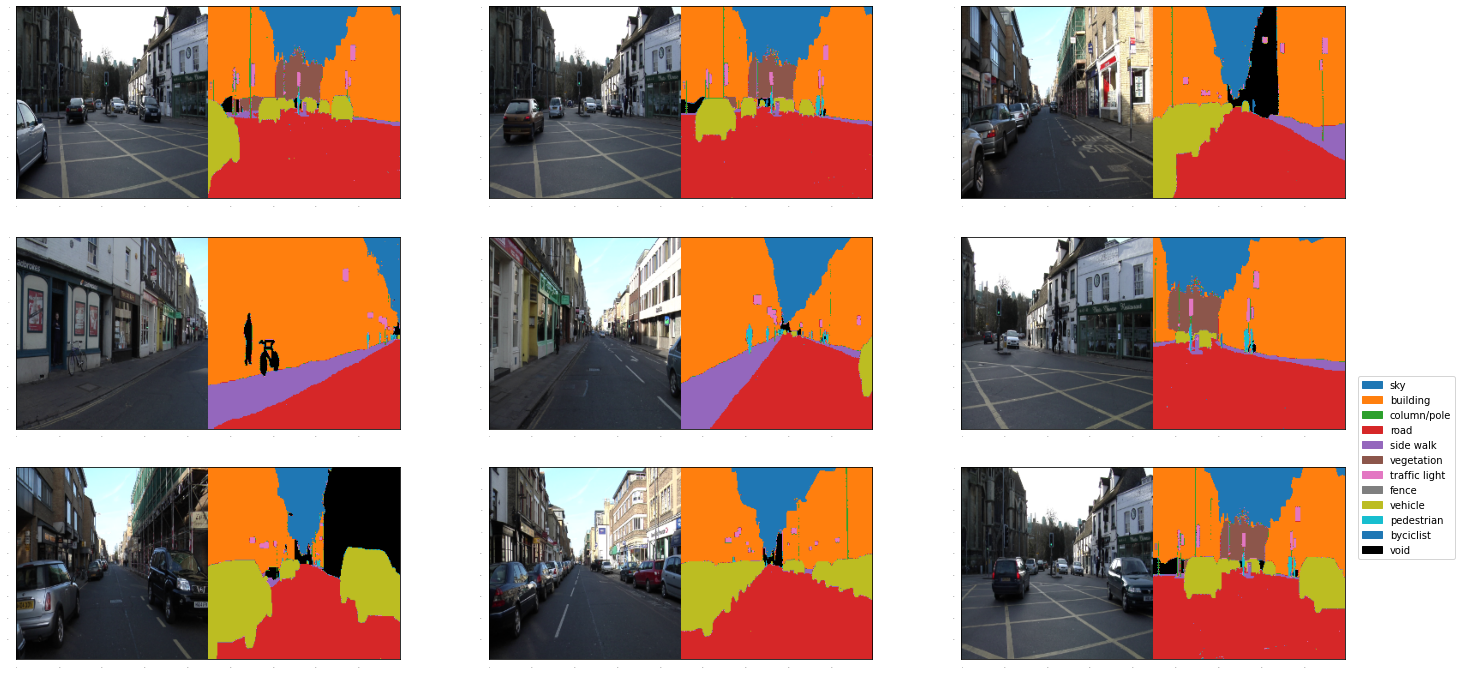

In [ ]:
def color_annotation(im):
    # (224, 224, 12)
    mask = np.zeros((224, 224, 3))
    im = im.numpy()

    for i in range(im.shape[-1]):
        ii, jj = np.where(im[:,:,i])
        mask[ii, jj, :] = colors[i] 
    return (mask*255).astype(np.uint16)

def show_image_mask(image, masks):
    choice = np.random.randint(0, image.shape[0], 9)
    
    fig, ax = plt.subplots(ncols = 3, nrows = 3, figsize = (24, 12))
    
    for i in range(9):
        mask = color_annotation(masks[choice[i]])
        im   = np.concatenate([np.uint16((image[choice[i]]+1)*127.5), mask], axis = 1)

        ax[int(i//3), int(i%3)].imshow(im)

    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=handles, bbox_to_anchor=(1.3, 1.5))
    # ax[1].legend(, class_names)
show_image_mask(i, j)

In [ ]:
def encoder(images):
    def encoder_block(x, n_convs = 2, kernel_size = (3, 3), filters = 32, pool_size = (2, 2), pool_stride = (2, 2), name = 'block'):
        for i in range(n_convs):
            x = tf.keras.layers.Conv2D(kernel_size = kernel_size, filters = filters, padding = 'same', activation = 'relu', name = f'{name}_conv{i}')(x)
        x = tf.keras.layers.MaxPool2D(pool_size, strides = (2, 2), name = f'{name}_pool{i}')(x)
        return x

    b1 = encoder_block(images, filters = 64, name = 'block1')
    b2 = encoder_block(b1, filters = 128, name = 'block2')
    b3 = encoder_block(b2, n_convs = 3, filters = 256, name = 'block3')
    b4 = encoder_block(b3, n_convs = 3, filters = 512, name = 'block4')
    b5 = encoder_block(b4, n_convs = 3, filters = 512, name = 'block5')

    vgg  = tf.keras.Model(images , b5)
    vgg.load_weights(weights_path) 
    
    c6 = tf.keras.layers.Conv2D(filters = 4096, kernel_size = (7, 7), activation = 'relu', padding = 'same', name = 'conv6')(b5)
    c7 = tf.keras.layers.Conv2D(filters = 4096, kernel_size = (1, 1), activation = 'relu', padding = 'same', name = 'conv7')(c6)

    return b1, b2, b3, b4, c7


def decoder(encoder_layers, K):
    b1,b2, b3, b4, c7 = encoder_layers

    d10 = tf.keras.layers.Conv2DTranspose(K, kernel_size=(4, 4),  strides=(2, 2), use_bias = False)(c7)
    d10 = tf.keras.layers.Cropping2D(cropping = (1, 1))(d10)
    d11 = tf.keras.layers.Conv2D(K, (1 , 1), activation='relu', padding='same')(b4)
    d1 = tf.keras.layers.Add()([d10, d11])


    d20 = tf.keras.layers.Conv2DTranspose(K, kernel_size=(4,4), strides=(2,2), use_bias = False)(d1)
    d20 = tf.keras.layers.Cropping2D(cropping = (1, 1))(d20)
    d21 = tf.keras.layers.Conv2D(K, (1 , 1), activation='relu', padding='same')(b3)
    d2 = tf.keras.layers.Add()([d20, d21])

    d3 = tf.keras.layers.Conv2DTranspose(K, kernel_size=(8,8),  strides=(8,8), use_bias = False)(d2)

    out = (tf.keras.layers.Activation('softmax'))(d3)

    return out

inputs = tf.keras.layers.Input(shape=(224,224,3,))
convs = encoder(inputs)
outputs = decoder(convs, 12)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
# for layer in model.layers[1:]:
#     if layer.name[:5] != 'block':
#         break
#     if 'conv' in layer.name:
#         layer.trainable = False
# model.summary()


In [ ]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#     print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy()

# print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
# sgd = tf.keras.optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)
sgd = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# number of training images
train_count = 367

# number of validation images
validation_count = 101

EPOCHS = 200

steps_per_epoch = train_count//64
validation_steps = validation_count//64

In [ ]:
history = model.fit(train, steps_per_epoch=steps_per_epoch, 
                    validation_data=test, validation_steps=validation_steps, 
                    epochs=EPOCHS, callbacks = [myCallback(),])

Epoch 1/200
5/5 [==============================] - 58s 6s/step - loss: 2.9917 - accuracy: 0.0843 - val_loss: 2.4872 - val_accuracy: 0.0912
Epoch 2/200
5/5 [==============================] - 11s 2s/step - loss: 2.4960 - accuracy: 0.0952 - val_loss: 2.4849 - val_accuracy: 0.0952
Epoch 3/200
5/5 [==============================] - 10s 2s/step - loss: 2.4851 - accuracy: 0.0852 - val_loss: 2.4866 - val_accuracy: 0.0823
Epoch 4/200
5/5 [==============================] - 9s 2s/step - loss: 2.4868 - accuracy: 0.0960 - val_loss: 2.5151 - val_accuracy: 0.1086
Epoch 5/200
5/5 [==============================] - 10s 2s/step - loss: 2.4941 - accuracy: 0.0986 - val_loss: 2.4848 - val_accuracy: 0.0970
Epoch 6/200
5/5 [==============================] - 9s 2s/step - loss: 2.4849 - accuracy: 0.1102 - val_loss: 2.4848 - val_accuracy: 0.1203
Epoch 7/200
5/5 [==============================] - 10s 2s/step - loss: 2.4775 - accuracy: 0.1268 - val_loss: 2.4692 - val_accuracy: 0.1326
Epoch 8/200
5/5 [============

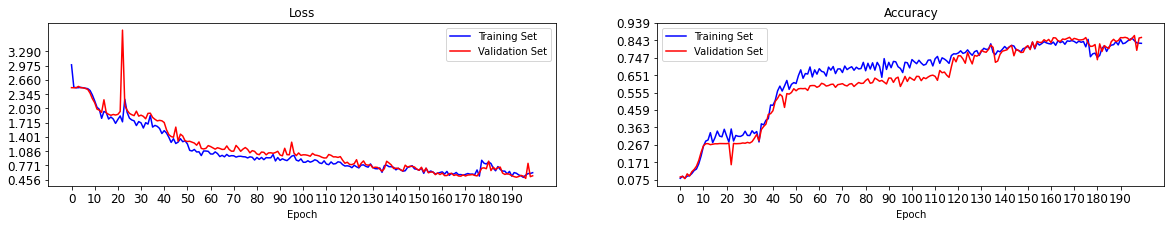

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize = (20, 3))
plots = [['loss', 'val_loss'], ['accuracy', 'val_accuracy']]
epochs = np.arange(len(history.history['loss']))

for i in [0, 1]:
  ax[i].plot(epochs, history.history[plots[i][0]], color = 'b', label = 'Training Set')
  ax[i].plot(epochs, history.history[plots[i][1]], color = 'r', label = 'Validation Set')
  ax[i].set_title(plots[i][0].capitalize())

  ax[i].tick_params(bottom=True, left=True)
  ax[i].set_xticks(epochs[::10])
  ax[i].set_xticklabels(epochs[::10], fontdict = {'fontsize':12,})

  ax[i].tick_params(bottom=True, left=True)
  ax[i].set_yticks(np.linspace( min( history.history[plots[i][0]])*0.9,  max(history.history[plots[i][0]])*1.1, 10 ))
  ax[i].set_yticklabels([str(j)[:5] for j in np.linspace( min( history.history[plots[i][0]])*0.9,  max(history.history[plots[i][0]])*1.1, 10 )], fontdict = {'fontsize':12,})
  ax[i].set_xlabel('Epoch')
  ax[i].legend()


In [ ]:
for im, mask in test.take(1):
  break
prediction = model.predict(im)
print(prediction.shape)

2/2 [==============================] - 4s 16ms/step
(64, 224, 224, 12)


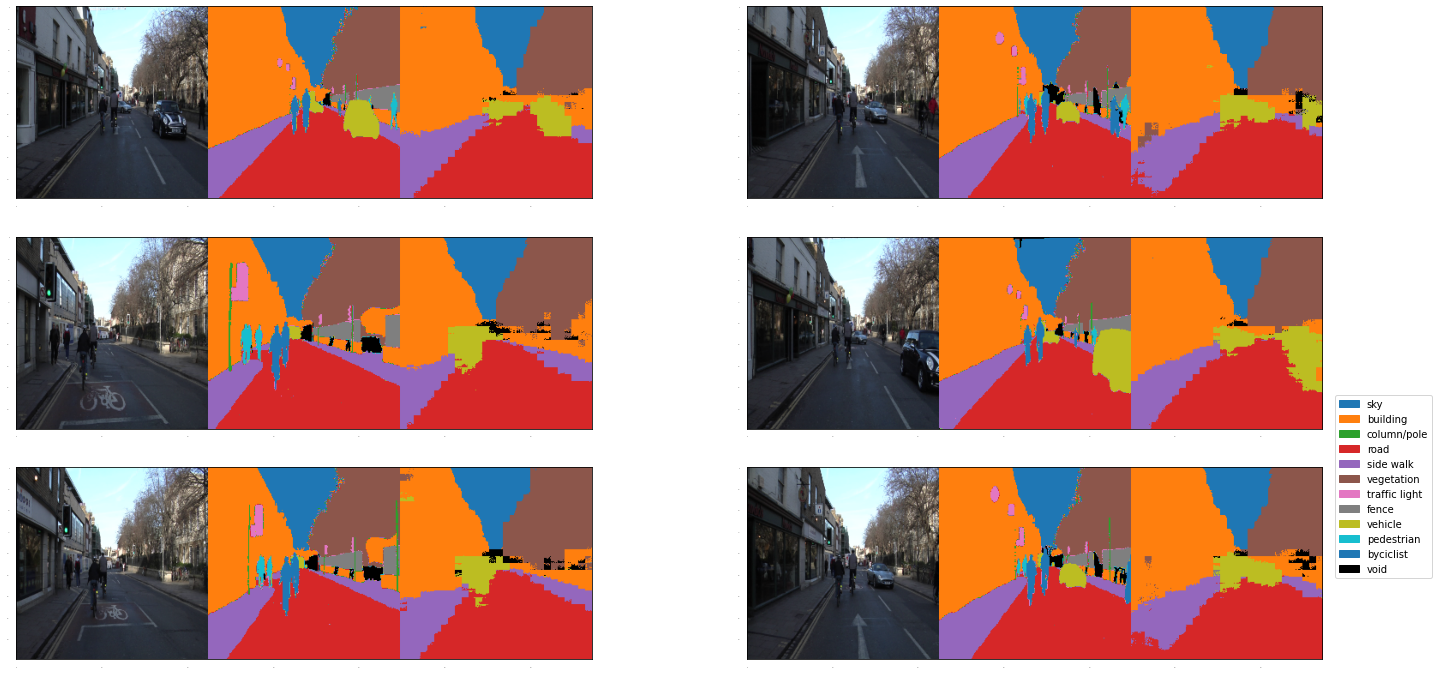

In [ ]:
def show_image_predictions(image, masks, predictions):
    choice = np.random.randint(0, image.shape[0], 6)
    fig, ax = plt.subplots(ncols = 2, nrows = 3, figsize = (24, 12))
    
    for i in range(6):
        pred = predictions[choice[i]]
        pmax = np.max(pred, axis = 2, keepdims = True)
        pout = np.isclose(pred, pmax).astype(int)
        pred = color_annotation(tf.convert_to_tensor(pout))

        mask = color_annotation(masks[choice[i]]) 
        im   = np.concatenate([np.uint16((image[choice[i]]+1)*127.5), mask], axis = 1)
        im   = np.concatenate([im, pred], axis = 1)
        ax[int(i//2), int(i%2)].imshow(im)

    import matplotlib.patches as mpatches
    handles = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
    plt.legend(handles=handles, bbox_to_anchor=(1.2, 1.4))
    # ax[1].legend(, class_names)
#must convert outputs to int. accross dimension 4 set the highest value to 1 and rest to 0
show_image_predictions(im, mask, tf.convert_to_tensor(prediction))


In [ ]:
mask_i = np.argmax(mask, axis = 3)
prediction_i = np.argmax(prediction, axis = 3)

iou = []
for i in range(12):
  overlap = np.sum((mask_i == i) * (prediction_i == i))
  in_pred = (prediction_i == i).sum()
  in_mask = (mask_i == i).sum()
  iou.append(overlap/(in_pred + in_mask - overlap))

for i in np.argsort(iou)[::-1]:
  print("For class {:^15} the IoU is \t {:0.04f}".format(class_names[i], iou[i]))



For class       sky       the IoU is 	 0.9061
For class      road       the IoU is 	 0.8922
For class   vegetation    the IoU is 	 0.8253
For class    building     the IoU is 	 0.8093
For class    side walk    the IoU is 	 0.7151
For class     vehicle     the IoU is 	 0.3758
For class      void       the IoU is 	 0.0762
For class      fence      the IoU is 	 0.0029
For class    byciclist    the IoU is 	 0.0000
For class   pedestrian    the IoU is 	 0.0000
For class  traffic light  the IoU is 	 0.0000
For class   column/pole   the IoU is 	 0.0000
